# Importing Necessary Libraries


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
import numpy as np
import matplotlib.pyplot as plt
import os
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Conv2D, BatchNormalization, Flatten, MaxPooling2D, LeakyReLU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import AdamW, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Prepapring Train and Test dataset




In [6]:
train_dir = "/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
test_dir = "/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test"
image_size = (180, 180)
batch_size = 32
class_names = ['Actinic Keratosis', 'Basal Cell Carcinoma', 'Dermatofibroma', 'Melanoma', 'Nevus', 'Pigmented Benign Keratosis', 'Seborrheic Keratosis', 'Squamous Cell Carcinoma', 'Vascular Lesion']


In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  labels='inferred',
  label_mode='categorical',
  image_size=image_size,
  interpolation='nearest',
  batch_size=batch_size,
  shuffle=True
)

Found 2239 files belonging to 9 classes.


In [8]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  labels='inferred',
  label_mode='categorical',
  image_size=image_size,
  interpolation='nearest',
  batch_size=batch_size,
  shuffle=True
)

Found 118 files belonging to 9 classes.


In [9]:
X_train = []
y_train = []

for images, labels in train_ds:
  X_train.append(images.numpy())
  y_train.append(labels.numpy())

X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)


In [10]:
X_test = []
y_test = []

for images, labels in test_ds:
  X_test.append(images.numpy())
  y_test.append(labels.numpy())

X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)


In [11]:
y_train.shape

(2239, 9)

In [12]:
y_test.shape

(118, 9)

In [13]:
X_train.shape

(2239, 180, 180, 3)

In [14]:
X_test.shape

(118, 180, 180, 3)

# Train dataset visualisation

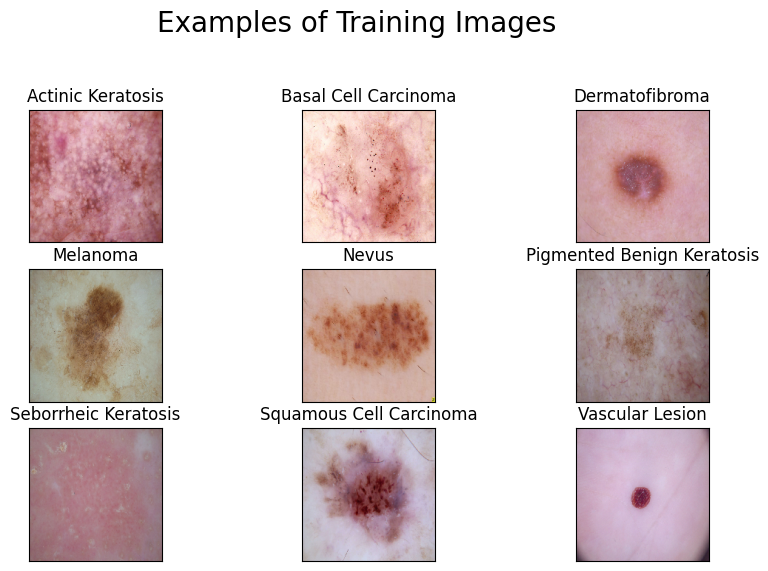

In [15]:
fig = plt.figure(figsize=(10, 10))
for i in range(y_train.shape[1]):
    ax = fig.add_subplot(5, 3, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:, i] == 1)[0]
    features_idx = X_train[idx, ::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num, ::]
    ax.set_title(class_names[i])
    plt.imshow(im.astype('uint8'))
fig.suptitle("Examples of Training Images", fontsize=20)
plt.show()

In [16]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

# Model Training

## Model 1
Sequential model with the following structure:


*   The model consists of two convolutional blocks with increasing filter sizes
*   Each block has three sets of convolutional layer, activation layer(RelU) and batch normalization followed by maxpooling and dropout
*   The convolutional blocks are followed by fully connected layers.
*   The final layer uses a softmax activation to predict the probability of each class.





In [17]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=X_train.shape[1:], padding="same", ))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), input_shape=X_train.shape[1:], padding="same", ))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), input_shape=X_train.shape[1:], padding="same", ))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same", ))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding="same", ))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding="same", ))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1]))
model.add(Activation('softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 180, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 180, 180, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 180, 180, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 180, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 180, 180, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 180, 180, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 180, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 180, 180, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 90, 90, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 90, 90, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 90, 90, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 90, 90, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 90, 90, 64)          │              

 Total params: 66,473,225 (253.58 MB)

 Trainable params: 66,472,649 (253.57 MB)

 Non-trainable params: 576 (2.25 KB)

In [19]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='sgd',
    metrics=['accuracy']
)

In [20]:
model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=20,
    validation_data=(X_test, y_test),
    shuffle=True,
    verbose=1
)

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 23s 193ms/step - accuracy: 0.2158 - loss: 17.8037 - val_accuracy: 0.1525 - val_loss: 3.8485
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.3909 - loss: 1.9639 - val_accuracy: 0.1356 - val_loss: 5.1722
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.4685 - loss: 1.5885 - val_accuracy: 0.1695 - val_loss: 3.2662
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.5326 - loss: 1.3660 - val_accuracy: 0.2712 - val_loss: 3.7150
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.5675 - loss: 1.2308 - val_accuracy: 0.2627 - val_loss: 3.5438
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.5928 - loss: 1.1950 - val_accuracy: 0.2203 - val_loss: 3.5497
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6594 - loss: 0.9565 - val_accuracy: 0.2712 - val_loss: 3.1048
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6777 - loss: 0.9591 - val_accuracy: 0.3390 

### Inference
As we can see from the above output, the model has vastly overfitted

## Model 2
Sequential model with the following structure:


*   The model consists of three convolutional blocks with increasing filter sizes
*   Each block has three sets of convolutional layer, activation layer(Leaky RelU) and batch normalization followed by maxpooling and dropout
*   The convolutional blocks are followed by fully connected layers.
*   The dense layer has a L2 regularization of 0.01
*   Using AdamW optimiser instead of SGD
*   The final layer uses a softmax activation to predict the probability of each class.


In [21]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.20,
    height_shift_range=0.20,
    shear_range=0.2,
    zoom_range=0.20,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [22]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

Found 2239 images belonging to 9 classes.


In [23]:
test_datagen = ImageDataGenerator()

In [24]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

Found 118 images belonging to 9 classes.


In [26]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=X_train.shape[1:], padding="same"))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3)))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3)))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))


model.add(Conv2D(64, (2, 2)))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3)))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3)))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (2, 2)))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3)))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3)))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, kernel_regularizer=l2(0.01)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1]))
model.add(Activation('softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [30]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005, weight_decay=0.01)
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

In [31]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 180, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 180, 180, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 178, 178, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 178, 178, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 178, 178, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 176, 176, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 176, 176, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 176, 176, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 58, 58, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 58, 58, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 57, 57, 64)          │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 57, 57, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 57, 57, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 55, 55, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 55, 55, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 55, 55, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 53, 53, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 53, 53, 32)          │              

 Total params: 360,009 (1.37 MB)

 Trainable params: 359,305 (1.37 MB)

 Non-trainable params: 704 (2.75 KB)

In [32]:
model.fit(
   train_generator,
    batch_size=batch_size,
    epochs=20,
    validation_data=test_generator,
    shuffle=True,
    verbose=1
)

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 63s 676ms/step - accuracy: 0.3095 - loss: 4.9195 - val_accuracy: 0.2119 - val_loss: 28.8015
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 42s 547ms/step - accuracy: 0.4068 - loss: 2.5352 - val_accuracy: 0.1102 - val_loss: 14.8185
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 42s 550ms/step - accuracy: 0.3983 - loss: 2.1184 - val_accuracy: 0.1525 - val_loss: 5.7775
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 42s 544ms/step - accuracy: 0.4286 - loss: 1.9614 - val_accuracy: 0.2288 - val_loss: 4.8061
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 42s 549ms/step - accuracy: 0.4451 - loss: 1.8572 - val_accuracy: 0.1864 - val_loss: 5.5516
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 42s 548ms/step - accuracy: 0.4662 - loss: 1.7582 - val_accuracy: 0.2966 - val_loss: 3.2540
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 42s 551ms/step - accuracy: 0.4720 - loss: 1.7441 - val_accuracy: 0.3051 - val_loss: 2.6558
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 42s 549ms/step - accuracy: 0.4609 - loss: 1.6961 - val_ac

### Inference
As we can observe, even though the overfitting has greatly reduced, the accuracy is still quite low for any practical use.

## Bayesian Optimization
Here we are using Bayesian Optimizer to find the best model.
The hyper parameters we are tuning are as follows:

*   Filter Size: 16 to 64 with a jump of 8
*   Kernel Size: 1 to 5 with a jump of 2
*   Depth: 2 to 5
*   Learning Rate: $10^{-6}$ to $10^{-2}$
*   Dropout: 0.2 to 0.7
*   L2 Regularization: $10^{-10}$ to $10^{-4}$


In [41]:
def create_model(params):
    model = Sequential()

    model.add(Conv2D(
        filters=int(params['filter_size']),
        kernel_size=int(params['kernel_size']),
        input_shape=X_train.shape[1:]
    ))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    for _ in range(int(params['depth']) - 1):
        model.add(Conv2D(
            filters=int(params['filter_size']),
            kernel_size=int(params['kernel_size']),
        ))
        model.add(LeakyReLU(alpha=0.1))
        model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(
        units=512,
        kernel_regularizer=l2(params['l2'])
    ))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(y_train.shape[1], activation='softmax'))

    optimizer = tf.keras.optimizers.AdamW(learning_rate=params['learning_rate'], weight_decay=0.01)

    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )
    return model

In [42]:
def objective(params):
    model = create_model(params)

    history = model.fit(
        train_generator,
        epochs=20,
        validation_data=test_generator,
        verbose=0
    )

    best_accuracy = max(history.history['val_accuracy'])
    loss = -best_accuracy

    trials.trials[-1]['result']['train_accuracy'] = history.history['accuracy'][-1]
    trials.trials[-1]['result']['test_accuracy'] = history.history['val_accuracy'][-1]


    return {
        'loss': loss,
        'status': STATUS_OK,
        'train_accuracy': history.history['accuracy'][-1],
        'test_accuracy': history.history['val_accuracy'][-1]
    }

In [43]:
search_space = {
    'depth': hp.quniform('depth', 2, 4, 1),
    'learning_rate': hp.loguniform('learning_rate', -3, -2),
    'filter_size': hp.quniform('filter_size', 32, 64, 32),
    'kernel_size': hp.quniform('kernel_size', 2, 3, 1),
    'dropout': hp.uniform('dropout', 0.2, 0.5),
    'l2': hp.loguniform('l2', -5, -2),
}

In [44]:
trials = Trials()
best = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=20,
    trials=trials
)

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(



100%|██████████| 20/20 [4:40:23<00:00, 841.16s/trial, best loss: -0.27966102957725525]


In [47]:
for trial in trials.trials:
  print(f"Trial {trial['tid']}:")
  print(f"  Train Accuracy: {trial['result']['train_accuracy']}")
  print(f"  Test Accuracy: {trial['result']['test_accuracy']}")
  print("-"*50)

Trial 0:
  Train Accuracy: 0.17731130123138428
  Test Accuracy: 0.10169491171836853
--------------------------------------------------
Trial 1:
  Train Accuracy: 0.2304600328207016
  Test Accuracy: 0.22033898532390594
--------------------------------------------------
Trial 2:
  Train Accuracy: 0.1737382709980011
  Test Accuracy: 0.1355932205915451
--------------------------------------------------
Trial 3:
  Train Accuracy: 0.1916033923625946
  Test Accuracy: 0.16949152946472168
--------------------------------------------------
Trial 4:
  Train Accuracy: 0.22510048747062683
  Test Accuracy: 0.17796610295772552
--------------------------------------------------
Trial 5:
  Train Accuracy: 0.192496657371521
  Test Accuracy: 0.20338982343673706
--------------------------------------------------
Trial 6:
  Train Accuracy: 0.19651630520820618
  Test Accuracy: 0.20338982343673706
--------------------------------------------------
Trial 7:
  Train Accuracy: 0.1902635097503662
  Test Accuracy

In [48]:
best_trial = max(trials.trials, key=lambda x: x['result']['test_accuracy'])

print("Best Trial:")
print(f"  Trial ID: {best_trial['tid']}")
print(f"  Train Accuracy: {best_trial['result']['train_accuracy']}")
print(f"  Test Accuracy: {best_trial['result']['test_accuracy']}")
print(f"  Hyperparameters: {best_trial['misc']['vals']}")

Best Trial:
  Trial ID: 18
  Train Accuracy: 0.21572130918502808
  Test Accuracy: 0.23728813230991364
  Hyperparameters: {'depth': [3.0], 'dropout': [0.22176884391198973], 'filter_size': [64.0], 'kernel_size': [3.0], 'l2': [0.02770818139973843], 'learning_rate': [0.10164610761481246]}


In [49]:
print("Best Hyperparameters:")
for key, value in best_trial['misc']['vals'].items():
    print(f"{key}: {value[0]}")  # Access the first element of the value list

Best Hyperparameters:
depth: 3.0
dropout: 0.22176884391198973
filter_size: 64.0
kernel_size: 3.0
l2: 0.02770818139973843
learning_rate: 0.10164610761481246


### Inference
After completing the hyper parameter tuning we get the following values as the best parameters tielding the best test accuracy:
*   Depth: 3.0
*   Dropout: 0.39266772879081135
*   Filter_size: 32.0
*   Kernel_size: 2.0
*   L2: 0.026321822067821677
*   Learning_rate: 0.06716190798341724


# Final Model
Rebuilding the final model with the previously acquired best hyper parameters

In [50]:
best_params = best_trial['misc']['vals']

In [51]:
best_model = create_model({
    'depth': best_params['depth'][0],
    'learning_rate': best_params['learning_rate'][0],
    'filter_size': best_params['filter_size'][0],
    'kernel_size': best_params['kernel_size'][0],
    'dropout': best_params['dropout'][0],
    'l2': best_params['l2'][0],
})

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [53]:
history = best_model.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator,
    verbose=1
)

Epoch 1/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 44s 581ms/step - accuracy: 0.1710 - loss: 58483261440.0000 - val_accuracy: 0.0847 - val_loss: 11191460864.0000
Epoch 2/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 42s 543ms/step - accuracy: 0.1996 - loss: 2328804352.0000 - val_accuracy: 0.2034 - val_loss: 2698502656.0000
Epoch 3/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 42s 544ms/step - accuracy: 0.1833 - loss: 1252244608.0000 - val_accuracy: 0.1695 - val_loss: 2006305280.0000
Epoch 4/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 42s 551ms/step - accuracy: 0.1838 - loss: 693471104.0000 - val_accuracy: 0.1441 - val_loss: 565182080.0000
Epoch 5/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 42s 546ms/step - accuracy: 0.1692 - loss: 291891392.0000 - val_accuracy: 0.2288 - val_loss: 384120512.0000
Epoch 6/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 42s 545ms/step - accuracy: 0.1607 - loss: 213215408.0000 - val_accuracy: 0.1102 - val_loss: 395580128.0000
Epoch 7/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 42s 543ms/step - accuracy: 0.1718 - loss: 118468792.0000 - val_accuracy: 0.2034 - va

# Conclusion
After retraining a model with the best hyper parameters we got from the Bayesian Optimization, we got the following result:
*   Train Accuracy - 22.84%
*   Test Accuracy - 22.03%